In [96]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
import urllib.parse
from datetime import datetime
import pytz
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Table of Content
* [Data Extraction](#Data-Extraction)
* [Data Preparation](#Data-Preparation)
    * [Customer Reach](#customer_reach)
    * [Customer Conversion](#customer_conversion)
    * [Customer Repurchase](#customer_repurchase)
* [EDA](#EDA)
    * [Age](#Age)
    * [Policy Impact](#Policy-Impact)
    * [Product Types](#Product-Types)
    * [Converted Time](#Converted-Time)  
    * [Trial Price Distribution](#Trial-Price-Distribution)
    * [Product Price](#Product-Price)
    * [Time-Series](#Time-Series)
* [Finalization](#Finalization)

# Data Extraction

In [98]:
cleaned_member = pd.read_csv('cleaned_member.csv')
cleaned_member_list = cleaned_member['user_id'].tolist()
cleaned_member

,user_id
0,131638
1,131639
2,131640
3,131641
4,131642
...,...
158085,16579599
158086,16579600
158087,16579601
158088,16579602


In [99]:
query1 = "SELECT attriid as attri_id, attriname as attri_name, attriname_en as attri_name_en, pid FROM ehailuo_attribute_info_glv"
attribute = pd.read_sql(query1, engine)
attribute

,attri_id,attri_name,attri_name_en,pid
0,1,小学生,Elementary Students,0.0
1,2,中学生,Junior/Senior Students,0.0
2,3,大学生,Undergraduates,0.0
3,4,销售/客服/采购,Sales/Customer Service/Purchase,0.0
4,5,IT/通信/电子,IT/Communication/E-commerce,0.0
...,...,...,...,...
2752,3188,CR30天停课学员回访,,NaN
2753,3189,青少儿应试,Young Learners Test Preparation,568.0
2754,3190,小红书投放,None,3172.0
2755,3191,星布小红书,None,1662.0


In [100]:
query2 = "SELECT userid as user_id, regdate as reg_date, product_want FROM ehailuo_member"
member = pd.read_sql(query2, engine)
member

,user_id,reg_date,product_want
0,100001,1399203423,567.0
1,100002,1399204559,567.0
2,100100,1399217597,567.0
3,113040,1397133620,568.0
4,113041,1397633140,567.0
...,...,...,...
238227,16583555,1691126431,568.0
238228,16583556,1691126972,568.0
238229,16583557,1691127055,568.0
238230,16583558,1691127179,1035.0


In [101]:
query3 = "SELECT userid as user_id, gender, age FROM ehailuo_member_detail"
member_detail = pd.read_sql(query3, engine)
member_detail

,user_id,gender,age
0,100001,1,413.0
1,113040,1,0.0
2,113043,0,418.0
3,113050,0,0.0
4,113086,0,0.0
...,...,...,...
243143,16583555,0,412.0
243144,16583556,0,412.0
243145,16583557,0,412.0
243146,16583558,1,413.0


In [102]:
query4 = "SELECT classorderid as class_order_id, classid as class_id, studentid as user_id, classorderstatus as class_order_status, paytype as pay_type  FROM ehailuo_class_orderlist_glv"
class_reservation = pd.read_sql(query4, engine)
class_reservation

,class_order_id,class_id,user_id,class_order_status,pay_type
0,1,39,401,3,1
1,2,52,402,1,1
2,3,50,401,0,1
3,4,44,401,2,1
4,5,54,401,1,1
...,...,...,...,...,...
1363159,1367343,2947044,16436773,1,21
1363160,1367344,2947052,16436773,1,21
1363161,1367345,2944426,16562053,1,25
1363162,1367346,2948240,16562053,1,25


In [103]:
query5 = "SELECT classid as class_id, starttime as start_time FROM ehailuo_class_schedule_glv"
class_detail = pd.read_sql(query5, engine)
class_detail

,class_id,start_time
0,41,1396146600
1,46,1396173600
2,42,1396175400
3,57,1396184400
4,58,1396186200
...,...,...
2939116,1525970,2121724800
2939117,1526865,2121728400
2939118,1527760,2121732000
2939119,1528655,2121807600


In [104]:
query6 = "SELECT userid as user_id, productid as product_id, productname as product_name, producttype as buy_type, adddate as add_date, effectivedate as effective_date, overduedate as overdue_date, lesson, unitprice as unit_price, productmoney as product_money FROM ehailuo_product_buy_glv"
order = pd.read_sql(query6, engine)
order.tail()

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
232056,16583554.0,26.0,体验卡,749.0,1.691126e+09,1.691126e+09,1.760159e+09,0.0,0.0,0.0
232057,16583551.0,26.0,体验卡,709.0,1.691126e+09,1.691126e+09,1.760160e+09,0.0,9.9,9.9
232058,16583555.0,26.0,体验卡,709.0,1.691126e+09,NaN,NaN,0.0,4.9,4.9
232059,16583445.0,26.0,体验卡,749.0,1.691127e+09,1.691128e+09,1.760161e+09,0.0,0.0,0.0
232060,16583558.0,26.0,体验卡,709.0,1.691127e+09,NaN,NaN,0.0,4.9,4.9


# Data Preparation

### customer_reach

In [105]:
customer_reach = member_detail.merge(member,on='user_id',how='inner')
customer_reach = customer_reach[customer_reach['user_id'].isin(cleaned_member_list)]
customer_reach

,user_id,gender,age,reg_date,product_want
18541,131638,1,420.0,1451536291,569.0
18542,131639,0,417.0,1451536531,567.0
18543,131640,0,413.0,1451538181,567.0
18544,131641,0,416.0,1451540380,567.0
18545,131642,0,420.0,1451547330,567.0
...,...,...,...,...,...
234233,16579599,0,412.0,1682859465,1035.0
234234,16579600,0,417.0,1682859819,567.0
234235,16579601,0,412.0,1682861069,1035.0
234236,16579602,0,419.0,1682865539,567.0


In [106]:
# Convert UNIX timestamps to datetime objects
customer_reach['reg_date'] = pd.to_datetime(customer_reach['reg_date'], unit='s')

# Set timezone to China timezone
china_tz = pytz.timezone('Asia/Shanghai')
customer_reach['reg_date'] = customer_reach['reg_date'].dt.tz_localize(pytz.utc).dt.tz_convert(china_tz)

# Extract yyyy-mm-dd format from datetime objects
customer_reach['reg_date'] = customer_reach['reg_date'].dt.strftime('%Y-%m-%d %H:%M')

customer_reach

,user_id,gender,age,reg_date,product_want
18541,131638,1,420.0,2015-12-31 12:31,569.0
18542,131639,0,417.0,2015-12-31 12:35,567.0
18543,131640,0,413.0,2015-12-31 13:03,567.0
18544,131641,0,416.0,2015-12-31 13:39,567.0
18545,131642,0,420.0,2015-12-31 15:35,567.0
...,...,...,...,...,...
234233,16579599,0,412.0,2023-04-30 20:57,1035.0
234234,16579600,0,417.0,2023-04-30 21:03,567.0
234235,16579601,0,412.0,2023-04-30 21:24,1035.0
234236,16579602,0,419.0,2023-04-30 22:38,567.0


In [107]:
customer_reach['after_policy'] = (customer_reach['reg_date'] > '2021-07-24').astype(int)

In [108]:
# Find the class that are paid/reserved by trial-class card in the account
trial_class_reservation = class_reservation[class_reservation['pay_type']==26]

# Find the trial class reservations that are completed successfully
trial_class_completed = trial_class_reservation[trial_class_reservation['class_order_status']==2]

# Filter the trial class completed by the cleaned_member_list
trial_class_completed = trial_class_completed[trial_class_completed['user_id'].isin(cleaned_member_list)]

In [109]:
trial_user_list = trial_class_completed['user_id'].unique().tolist()
customer_reach['trial_completed'] = customer_reach['user_id'].apply(lambda x: 1 if x in trial_user_list else 0)
customer_reach

,user_id,gender,age,reg_date,product_want,after_policy,trial_completed
18541,131638,1,420.0,2015-12-31 12:31,569.0,0,1
18542,131639,0,417.0,2015-12-31 12:35,567.0,0,0
18543,131640,0,413.0,2015-12-31 13:03,567.0,0,1
18544,131641,0,416.0,2015-12-31 13:39,567.0,0,1
18545,131642,0,420.0,2015-12-31 15:35,567.0,0,0
...,...,...,...,...,...,...,...
234233,16579599,0,412.0,2023-04-30 20:57,1035.0,1,0
234234,16579600,0,417.0,2023-04-30 21:03,567.0,1,0
234235,16579601,0,412.0,2023-04-30 21:24,1035.0,1,1
234236,16579602,0,419.0,2023-04-30 22:38,567.0,1,1


In [110]:
# Get the product type list
product_list = order[['product_id', 'product_name']].drop_duplicates()

# Sort the values in ascending order
product_list = product_list.sort_values('product_id')

product_list

,product_id,product_name
144789,0.0,None
2,17.0,海螺币
19447,17.0,体验卡
0,21.0,菲律宾外教
1834,21.0,菲律宾外教次卡
1776,23.0,专业中教
1838,23.0,专业中教次卡
1862,24.0,测评卡
1,25.0,欧美外教次卡
106075,25.0,欧美外交次卡


In [111]:
# According to DBeaver data filtering, 17 is for 海螺币, 26 is for 体验卡
# 17 for 体验卡 is outlier
product_outlier = order[(order['product_id'] == 17) & (order['product_name'] == '体验卡')]
product_outlier

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
19447,141080.0,17.0,体验卡,690.0,1.471422e+09,NaN,NaN,0.0,0.0,0.0
19450,141081.0,17.0,体验卡,690.0,1.471422e+09,NaN,NaN,0.0,0.0,0.0
19451,141082.0,17.0,体验卡,690.0,1.471423e+09,1.471423e+09,1.472027e+09,0.0,0.0,0.0
19452,141084.0,17.0,体验卡,690.0,1.471423e+09,1.471423e+09,1.472028e+09,0.0,0.0,0.0


In [112]:
# Check the buy_type of the outliers
attribute_buy_type_outlier = attribute[attribute['attri_id']==690]
attribute_buy_type_outlier

,attri_id,attri_name,attri_name_en,pid
563,690,受邀注册赠送体验卡,None,739.0


In [113]:
# Get the orders of all the trial classes
trial_order = order[order['product_id']==26]

# Add the free trial (product id = 17) to the table
trial_order = pd.concat([trial_order,product_outlier],axis=0)
trial_order

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
2129,119379.0,26.0,体验卡,104.0,1.439521e+09,1.439521e+09,1.577808e+09,0.0,0.0,0.0
2131,119241.0,26.0,体验卡,389.0,1.439534e+09,1.439534e+09,1.577808e+09,0.0,0.0,0.0
2134,119439.0,26.0,体验卡,104.0,1.439539e+09,1.439710e+09,1.577808e+09,0.0,39.0,39.0
2135,119439.0,26.0,体验卡,104.0,1.439539e+09,NaN,NaN,0.0,39.0,39.0
2136,119441.0,26.0,体验卡,104.0,1.439539e+09,1.439545e+09,1.577808e+09,0.0,39.0,39.0
...,...,...,...,...,...,...,...,...,...,...
232060,16583558.0,26.0,体验卡,709.0,1.691127e+09,NaN,NaN,0.0,4.9,4.9
19447,141080.0,17.0,体验卡,690.0,1.471422e+09,NaN,NaN,0.0,0.0,0.0
19450,141081.0,17.0,体验卡,690.0,1.471422e+09,NaN,NaN,0.0,0.0,0.0
19451,141082.0,17.0,体验卡,690.0,1.471423e+09,1.471423e+09,1.472027e+09,0.0,0.0,0.0


In [114]:
# Filter the trial order by member_analysis_list
trial_order = trial_order[trial_order['user_id'].isin(cleaned_member_list)]

In [115]:
# Group 'trial_order' by 'userid' and calculate the mean of 'product_money'
trial_money = trial_order.groupby('user_id')['product_money'].mean().reset_index()

customer_reach = customer_reach.merge(trial_money, on='user_id', how='left')
customer_reach

,user_id,gender,age,reg_date,product_want,after_policy,trial_completed,product_money
0,131638,1,420.0,2015-12-31 12:31,569.0,0,1,38.00
1,131639,0,417.0,2015-12-31 12:35,567.0,0,0,9.90
2,131640,0,413.0,2015-12-31 13:03,567.0,0,1,9.90
3,131641,0,416.0,2015-12-31 13:39,567.0,0,1,19.60
4,131642,0,420.0,2015-12-31 15:35,567.0,0,0,19.60
...,...,...,...,...,...,...,...,...
158085,16579599,0,412.0,2023-04-30 20:57,1035.0,1,0,4.90
158086,16579600,0,417.0,2023-04-30 21:03,567.0,1,0,9.90
158087,16579601,0,412.0,2023-04-30 21:24,1035.0,1,1,4.90
158088,16579602,0,419.0,2023-04-30 22:38,567.0,1,1,0.00


### customer_conversion

In [182]:
customer_conversion = customer_reach[customer_reach['trial_completed'] == 1].copy()
customer_conversion = customer_conversion.drop('trial_completed',axis=1)
customer_conversion

,user_id,gender,age,reg_date,product_want,after_policy,product_money,year_month
0,131638,1,420.0,2015-12-31 12:31:00,569.0,0,38.00,2015-12
2,131640,0,413.0,2015-12-31 13:03:00,567.0,0,9.90,2015-12
3,131641,0,416.0,2015-12-31 13:39:00,567.0,0,19.60,2015-12
5,131643,1,418.0,2015-12-31 16:01:00,567.0,0,19.60,2015-12
6,131644,1,NaN,2015-12-31 16:09:00,567.0,0,0.00,2015-12
...,...,...,...,...,...,...,...,...
158082,16579596,0,412.0,2023-04-30 19:57:00,1035.0,1,4.90,2023-04
158083,16579597,0,412.0,2023-04-30 20:03:00,1035.0,1,4.90,2023-04
158087,16579601,0,412.0,2023-04-30 21:24:00,1035.0,1,4.90,2023-04
158088,16579602,0,419.0,2023-04-30 22:38:00,567.0,1,0.00,2023-04


In [183]:
official_order = order[order['product_id'].isin([21,23,25,27,28,32,33,34,35,38,42,62,64,66])]

In [184]:
buy_type_list = official_order['buy_type'].unique().tolist()
attribute_buy_type = attribute[attribute['attri_id'].isin(buy_type_list)]
print(attribute_buy_type.to_string())

      attri_id         attri_name                    attri_name_en     pid
3            4           销售/客服/采购  Sales/Customer Service/Purchase     0.0
98         104              体验课充值                             None     0.0
99         105               升级充值                             None     0.0
100        107               续费充值                             None     0.0
104        111             推荐学员奖励                             None     0.0
111        118         被推荐奖励免费体验课                             None     0.0
112        120               其他奖励                             None     0.0
113        121                 赠送                             None     0.0
119        131                 约课                             None     0.0
188        252               课程补偿                             None     0.0
189        253              有效期延期                             None     0.0
202        267               直接付费                             None     0.0
256        337           

In [185]:
buy_type_new = attribute_buy_type[attribute_buy_type['attri_name'].isin(['升级充值','直接付费','官网自己充值','新签','新签升级',
                                                            '推荐升级','推荐直接付费','新签扩包'])]

In [186]:
order_new = official_order[official_order['buy_type'].isin(buy_type_new['attri_id'])]
order_new

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
0,113040.0,21.0,菲律宾外教,105.0,NaN,1.412930e+09,1.415522e+09,16.0,0.0,0.0
1,113040.0,25.0,欧美外教次卡,105.0,NaN,1.412930e+09,1.415522e+09,14.0,0.0,0.0
3,113040.0,21.0,菲律宾外教,105.0,NaN,1.412742e+09,1.415334e+09,16.0,0.0,0.0
4,113040.0,25.0,欧美外教次卡,105.0,NaN,1.412742e+09,1.415334e+09,14.0,0.0,0.0
8,113040.0,21.0,菲律宾外教,105.0,1.412956e+09,1.412958e+09,1.415550e+09,16.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
231721,16581657.0,25.0,欧美外教次卡,715.0,1.690816e+09,NaN,NaN,49.0,181.6,8900.0
231747,16582421.0,25.0,欧美外教次卡,710.0,1.690872e+09,1.690872e+09,1.703832e+09,50.0,180.0,8999.0
231780,16583167.0,25.0,欧美外教次卡,710.0,1.690880e+09,1.690966e+09,1.703926e+09,50.0,180.0,8999.0
231996,16582570.0,23.0,专业中教次卡,710.0,1.691053e+09,NaN,NaN,32.0,169.0,5408.0


In [187]:
order_new = order_new[order_new['product_money']!=0]
order_new = order_new[order_new['lesson']>=5]
order_new = order_new[order_new['user_id'].isin(cleaned_member_list)]
order_new

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
5749,131650.0,21.0,菲律宾外教次卡,105.0,1.451713e+09,1.452308e+09,1.460602e+09,32.0,70.1,2244.0
5750,131669.0,25.0,欧美外教次卡,105.0,1.451713e+09,1.455611e+09,1.468053e+09,48.0,149.4,7172.0
5770,131648.0,25.0,欧美外教次卡,105.0,1.451875e+09,1.452072e+09,1.454146e+09,8.0,143.0,1144.0
5845,131698.0,25.0,欧美外教次卡,105.0,1.451976e+09,1.451979e+09,1.464680e+09,49.0,146.0,7152.0
5849,131730.0,25.0,欧美外教次卡,105.0,1.451982e+09,1.452816e+09,1.456963e+09,16.0,138.9,2223.0
...,...,...,...,...,...,...,...,...,...,...
231251,16569641.0,25.0,欧美外教次卡,710.0,1.690518e+09,1.690789e+09,1.703749e+09,50.0,180.0,8999.0
231506,16571932.0,25.0,欧美外教次卡,3000.0,1.690710e+09,NaN,NaN,28.0,184.2,5159.0
231514,16576688.0,25.0,欧美外教次卡,715.0,1.690717e+09,1.690717e+09,1.703159e+09,48.0,187.5,8999.0
231618,16561991.0,25.0,欧美外教次卡,710.0,1.690796e+09,NaN,NaN,9.0,222.2,2000.0


In [188]:
order_new_sorted = order_new.sort_values(by='add_date', ascending=True)
order_new_first = order_new_sorted.drop_duplicates(subset='user_id', keep='first')
order_new_first

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
5749,131650.0,21.0,菲律宾外教次卡,105.0,1.451713e+09,1.452308e+09,1.460602e+09,32.0,70.1,2244.0
5750,131669.0,25.0,欧美外教次卡,105.0,1.451713e+09,1.455611e+09,1.468053e+09,48.0,149.4,7172.0
5770,131648.0,25.0,欧美外教次卡,105.0,1.451875e+09,1.452072e+09,1.454146e+09,8.0,143.0,1144.0
5845,131698.0,25.0,欧美外教次卡,105.0,1.451976e+09,1.451979e+09,1.464680e+09,49.0,146.0,7152.0
5849,131730.0,25.0,欧美外教次卡,105.0,1.451982e+09,1.452816e+09,1.456963e+09,16.0,138.9,2223.0
...,...,...,...,...,...,...,...,...,...,...
230940,16561497.0,25.0,欧美外教次卡,710.0,1.690283e+09,1.690789e+09,1.703749e+09,50.0,180.0,8999.0
231251,16569641.0,25.0,欧美外教次卡,710.0,1.690518e+09,1.690789e+09,1.703749e+09,50.0,180.0,8999.0
231514,16576688.0,25.0,欧美外教次卡,715.0,1.690717e+09,1.690717e+09,1.703159e+09,48.0,187.5,8999.0
231618,16561991.0,25.0,欧美外教次卡,710.0,1.690796e+09,NaN,NaN,9.0,222.2,2000.0


In [189]:
converted_user_list = order_new_first['user_id'].tolist()
customer_conversion['if_converted'] = customer_conversion['user_id'].apply(lambda x: 1 if x in converted_user_list else 0)
customer_conversion

,user_id,gender,age,reg_date,product_want,after_policy,product_money,year_month,if_converted
0,131638,1,420.0,2015-12-31 12:31:00,569.0,0,38.00,2015-12,0
2,131640,0,413.0,2015-12-31 13:03:00,567.0,0,9.90,2015-12,0
3,131641,0,416.0,2015-12-31 13:39:00,567.0,0,19.60,2015-12,0
5,131643,1,418.0,2015-12-31 16:01:00,567.0,0,19.60,2015-12,0
6,131644,1,NaN,2015-12-31 16:09:00,567.0,0,0.00,2015-12,0
...,...,...,...,...,...,...,...,...,...
158082,16579596,0,412.0,2023-04-30 19:57:00,1035.0,1,4.90,2023-04,0
158083,16579597,0,412.0,2023-04-30 20:03:00,1035.0,1,4.90,2023-04,0
158087,16579601,0,412.0,2023-04-30 21:24:00,1035.0,1,4.90,2023-04,0
158088,16579602,0,419.0,2023-04-30 22:38:00,567.0,1,0.00,2023-04,1


### customer_repurchase

In [124]:
# Convert UNIX timestamps to datetime objects
order_new_first['add_date'] = pd.to_datetime(order_new_first['add_date'], unit='s')
order_new_first['effective_date'] = pd.to_datetime(order_new_first['effective_date'], unit='s')
order_new_first['overdue_date'] = pd.to_datetime(order_new_first['overdue_date'], unit='s')

# Set timezone to China timezone
china_tz = pytz.timezone('Asia/Shanghai')
order_new_first['add_date'] = order_new_first['add_date'].dt.tz_localize(pytz.utc).dt.tz_convert(china_tz)
order_new_first['effective_date'] = order_new_first['effective_date'].dt.tz_localize(pytz.utc).dt.tz_convert(china_tz)
order_new_first['overdue_date'] = order_new_first['overdue_date'].dt.tz_localize(pytz.utc).dt.tz_convert(china_tz)

# Extract yyyy-mm-dd format from datetime objects
order_new_first['add_date'] = order_new_first['add_date'].dt.strftime('%Y-%m-%d %H:%M')
order_new_first['effective_date'] = order_new_first['effective_date'].dt.strftime('%Y-%m-%d %H:%M')
order_new_first['overdue_date'] = order_new_first['overdue_date'].dt.strftime('%Y-%m-%d %H:%M')

order_new_first.rename(columns={'add_date': 'order_date'}, inplace=True)

order_new_first

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/3622675850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_new_first['add_date'] = pd.to_datetime(order_new_first['add_date'], unit='s')
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/3622675850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_new_first['effective_date'] = pd.to_datetime(order_new_first['effective_date'], unit='s')
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/3622675850.

,user_id,product_id,product_name,buy_type,order_date,effective_date,overdue_date,lesson,unit_price,product_money
5749,131650.0,21.0,菲律宾外教次卡,105.0,2016-01-02 13:29,2016-01-09 10:52,2016-04-14 10:52,32.0,70.1,2244.0
5750,131669.0,25.0,欧美外教次卡,105.0,2016-01-02 13:30,2016-02-16 16:29,2016-07-09 16:29,48.0,149.4,7172.0
5770,131648.0,25.0,欧美外教次卡,105.0,2016-01-04 10:29,2016-01-06 17:22,2016-01-30 17:22,8.0,143.0,1144.0
5845,131698.0,25.0,欧美外教次卡,105.0,2016-01-05 14:32,2016-01-05 15:36,2016-05-31 15:36,49.0,146.0,7152.0
5849,131730.0,25.0,欧美外教次卡,105.0,2016-01-05 16:18,2016-01-15 07:56,2016-03-03 07:56,16.0,138.9,2223.0
...,...,...,...,...,...,...,...,...,...,...
230940,16561497.0,25.0,欧美外教次卡,710.0,2023-07-25 19:10,2023-07-31 15:43,2023-12-28 15:43,50.0,180.0,8999.0
231251,16569641.0,25.0,欧美外教次卡,710.0,2023-07-28 12:18,2023-07-31 15:32,2023-12-28 15:32,50.0,180.0,8999.0
231514,16576688.0,25.0,欧美外教次卡,715.0,2023-07-30 19:35,2023-07-30 19:44,2023-12-21 19:44,48.0,187.5,8999.0
231618,16561991.0,25.0,欧美外教次卡,710.0,2023-07-31 17:40,NaN,NaN,9.0,222.2,2000.0


In [125]:
order_new_activated = order_new_first[~order_new_first['effective_date'].isnull()]
order_new_completed = order_new_activated[(order_new_activated['overdue_date'] < '2023-04-30') & (order_new_activated['overdue_date'] > '2014-01-01')]
order_new_completed = order_new_completed.drop(order_new_completed[order_new_completed['effective_date'] == order_new_completed['overdue_date']].index)
order_new_completed

,user_id,product_id,product_name,buy_type,order_date,effective_date,overdue_date,lesson,unit_price,product_money
5749,131650.0,21.0,菲律宾外教次卡,105.0,2016-01-02 13:29,2016-01-09 10:52,2016-04-14 10:52,32.0,70.1,2244.0
5750,131669.0,25.0,欧美外教次卡,105.0,2016-01-02 13:30,2016-02-16 16:29,2016-07-09 16:29,48.0,149.4,7172.0
5770,131648.0,25.0,欧美外教次卡,105.0,2016-01-04 10:29,2016-01-06 17:22,2016-01-30 17:22,8.0,143.0,1144.0
5845,131698.0,25.0,欧美外教次卡,105.0,2016-01-05 14:32,2016-01-05 15:36,2016-05-31 15:36,49.0,146.0,7152.0
5849,131730.0,25.0,欧美外教次卡,105.0,2016-01-05 16:18,2016-01-15 07:56,2016-03-03 07:56,16.0,138.9,2223.0
...,...,...,...,...,...,...,...,...,...,...
215160,16575719.0,25.0,欧美外教次卡,715.0,2023-01-30 15:12,2023-01-30 15:13,2023-03-31 15:13,20.0,219.0,4380.0
216212,16576144.0,25.0,欧美外教次卡,710.0,2023-02-11 17:40,2023-02-14 10:20,2023-03-16 10:20,10.0,219.0,2190.0
217224,16576983.0,25.0,欧美外教次卡,710.0,2023-02-23 13:09,2023-02-24 18:38,2023-04-21 18:38,8.0,219.0,1752.0
217735,16577191.0,25.0,欧美外教次卡,710.0,2023-02-28 21:21,2023-03-01 17:21,2023-03-31 17:21,10.0,220.0,2200.0


In [194]:
member_repurchase_analysis = order_new_completed['user_id'].unique().tolist()
customer_repurchase = customer_reach[customer_reach['user_id'].isin(member_repurchase_analysis)]

customer_repurchase = customer_repurchase.drop('trial_completed',axis=1)
customer_repurchase = customer_repurchase.drop('product_money',axis=1)

customer_repurchase

,user_id,gender,age,reg_date,product_want,after_policy,year_month
9,131647,0,420.0,2015-12-31 18:11:00,569.0,0,2015-12
10,131648,0,420.0,2015-12-31 20:02:00,567.0,0,2015-12
12,131650,0,NaN,2015-12-31 21:07:00,1035.0,0,2015-12
25,131663,0,411.0,2016-01-01 20:22:00,569.0,0,2016-01
27,131665,1,412.0,2016-01-01 22:26:00,1035.0,0,2016-01
...,...,...,...,...,...,...,...
154761,16575719,0,413.0,2023-01-26 11:42:00,1035.0,1,2023-01
155147,16576144,1,NaN,2023-02-07 10:15:00,1035.0,1,2023-02
155874,16576983,0,414.0,2023-02-23 13:08:00,567.0,1,2023-02
156064,16577191,0,NaN,2023-02-28 10:46:00,1035.0,1,2023-02


In [195]:
repurchase_type = attribute_buy_type[attribute_buy_type['attri_name'].isin(['续费充值','续费'])]

In [196]:
order_repurchase = official_order[official_order['buy_type'].isin(repurchase_type['attri_id'])]
order_repurchase

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
1748,114733.0,21.0,菲律宾外教,107.0,1.437724e+09,1.437881e+09,1.443929e+09,10.0,49.0,490.0
1794,118031.0,23.0,专业中教,107.0,1.437982e+09,1.437987e+09,1.440406e+09,4.0,119.0,476.0
1834,119018.0,21.0,菲律宾外教次卡,107.0,1.438138e+09,1.438170e+09,1.442318e+09,16.0,49.0,784.0
1853,119029.0,25.0,欧美外教次卡,107.0,1.438231e+09,NaN,NaN,1.0,169.0,169.0
1865,117276.0,25.0,欧美外教次卡,107.0,1.438244e+09,1.440403e+09,1.444550e+09,16.0,118.2,1892.0
...,...,...,...,...,...,...,...,...,...,...
231673,16564859.0,25.0,欧美外教次卡,713.0,1.690807e+09,NaN,NaN,50.0,180.0,8999.0
231719,16569229.0,25.0,欧美外教次卡,713.0,1.690816e+09,NaN,NaN,33.0,202.7,6688.0
231760,16579355.0,25.0,欧美外教次卡,713.0,1.690877e+09,NaN,NaN,32.0,209.0,6688.0
231762,16569630.0,25.0,欧美外教次卡,713.0,1.690878e+09,NaN,NaN,50.0,180.0,8999.0


In [197]:
# userid who have mutiple new orders
new_order_per_user = order_new['user_id'].value_counts()
user_with_multiple_new_orders = new_order_per_user[new_order_per_user > 1].index.tolist()

In [198]:
repurchase_user = order_repurchase['user_id'].unique().tolist()
repurchase_user.extend(user_with_multiple_new_orders)

customer_repurchase['if_repurchase'] = customer_repurchase['user_id'].apply(lambda x: 1 if x in repurchase_user else 0)
customer_repurchase

,user_id,gender,age,reg_date,product_want,after_policy,year_month,if_repurchase
9,131647,0,420.0,2015-12-31 18:11:00,569.0,0,2015-12,0
10,131648,0,420.0,2015-12-31 20:02:00,567.0,0,2015-12,0
12,131650,0,NaN,2015-12-31 21:07:00,1035.0,0,2015-12,0
25,131663,0,411.0,2016-01-01 20:22:00,569.0,0,2016-01,0
27,131665,1,412.0,2016-01-01 22:26:00,1035.0,0,2016-01,0
...,...,...,...,...,...,...,...,...
154761,16575719,0,413.0,2023-01-26 11:42:00,1035.0,1,2023-01,1
155147,16576144,1,NaN,2023-02-07 10:15:00,1035.0,1,2023-02,1
155874,16576983,0,414.0,2023-02-23 13:08:00,567.0,1,2023-02,0
156064,16577191,0,NaN,2023-02-28 10:46:00,1035.0,1,2023-02,1


In [199]:
customer_repurchase = customer_repurchase.merge(order_new_completed[['user_id','product_money']], on='user_id',how='left')
customer_repurchase

,user_id,gender,age,reg_date,product_want,after_policy,year_month,if_repurchase,product_money
0,131647,0,420.0,2015-12-31 18:11:00,569.0,0,2015-12,0,13351.0
1,131648,0,420.0,2015-12-31 20:02:00,567.0,0,2015-12,0,1144.0
2,131650,0,NaN,2015-12-31 21:07:00,1035.0,0,2015-12,0,2244.0
3,131663,0,411.0,2016-01-01 20:22:00,569.0,0,2016-01,0,1390.0
4,131665,1,412.0,2016-01-01 22:26:00,1035.0,0,2016-01,0,7871.0
...,...,...,...,...,...,...,...,...,...
10245,16575719,0,413.0,2023-01-26 11:42:00,1035.0,1,2023-01,1,4380.0
10246,16576144,1,NaN,2023-02-07 10:15:00,1035.0,1,2023-02,1,2190.0
10247,16576983,0,414.0,2023-02-23 13:08:00,567.0,1,2023-02,0,1752.0
10248,16577191,0,NaN,2023-02-28 10:46:00,1035.0,1,2023-02,1,2200.0


# EDA

### Age

In [132]:
customer_reach['age'].info()

<class 'pandas.core.series.Series'>
Int64Index: 158090 entries, 0 to 158089
Series name: age
Non-Null Count   Dtype  
--------------   -----  
139398 non-null  float64
dtypes: float64(1)
memory usage: 2.4 MB


In [133]:
customer_reach['age'].replace(0,np.nan,inplace=True)
member_age = customer_reach.dropna(subset=['age'])

In [134]:
member_age['age'].value_counts()

418.0     19347
416.0     16074
417.0     12899
412.0      9084
419.0      7090
420.0      6332
411.0      1973
1004.0     1934
1504.0     1726
413.0      1624
414.0      1522
1503.0      646
1505.0      309
1002.0      219
1507.0       76
1003.0       68
1506.0       58
415.0         2
Name: age, dtype: int64

In [135]:
age_list = member_age['age'].unique().tolist()
attribute_age = attribute[attribute['attri_id'].isin(age_list)]
attribute_age

,attri_id,attri_name,attri_name_en,pid
324,411,学前,Pre-school,0.0
325,412,小学,Primary school,0.0
326,413,初中,Middle school,0.0
327,414,高中,High school,0.0
328,416,大学,University / College,0.0
329,417,工作不足1年,Have been working for less than 1 year,0.0
330,418,工作1-3年,Have been working for 1-3 years,0.0
331,419,工作3-5年,Have been working for 3-5 years,0.0
332,420,工作5到10年,Have been working for 5-10 years,0.0
779,1002,硕士,None,0.0


In [136]:
child_age = [411,412,413,414,1503,1504,1505,1506]
member_age['is_child'] = member_age['age'].isin(child_age).apply(lambda x: 1 if x else 0)
member_age['is_child'].value_counts()

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/3104712401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member_age['is_child'] = member_age['age'].isin(child_age).apply(lambda x: 1 if x else 0)


0    64041
1    16942
Name: is_child, dtype: int64

In [137]:
child_age = member_age[member_age['is_child'] == 1].copy()
adult_age = member_age[member_age['is_child'] == 0].copy()

In [138]:
child_age['gender'].value_counts()

0    10942
1     6000
Name: gender, dtype: int64

In [139]:
adult_age['gender'].value_counts()

0    51835
1    12206
Name: gender, dtype: int64

In [140]:
# Calculate the percentages for each category
adult_male = len(adult_age[adult_age['gender'] == 1])/ len(member_age)
adult_female = len(adult_age[adult_age['gender'] == 0])/ len(member_age)
child_male = len(child_age[child_age['gender'] == 1])/ len(member_age)
child_female = len(child_age[child_age['gender'] == 0])/ len(member_age)
print(adult_male,adult_female,child_male,child_female)

0.15072299124507613 0.6400726078312732 0.07408962374819407 0.13511477717545659


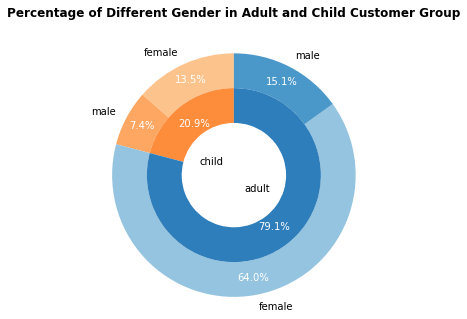

In [141]:
fig, ax = plt.subplots()

groups = ['female', 'male', 'female', 'male']
percentages = [child_female,child_male,adult_female,adult_male]
            
cmap_orange = plt.get_cmap("Oranges") 
cmap_blue = plt.get_cmap("Blues") 
outer_colors = np.concatenate([cmap_orange(np.linspace(0.3, 0.4, 2)), cmap_blue(np.linspace(0.4, 0.6, len(groups) - 2))])
wedges, texts, autotexts = ax.pie(percentages, labels=groups, 
                                  autopct='%1.1f%%', startangle=90, 
                                  colors=outer_colors, labeldistance=1.1,
                                  pctdistance=0.86, wedgeprops=dict(width=0.4), radius=1.4)

plt.setp(autotexts, color='white')

inner_groups = ['child', 'adult']
inner_percentages = [sum(percentages[:2]), sum(percentages[2:])]
inner_colors = [cmap_orange(0.5), cmap_blue(0.7)]
inner_wedges, inner_texts, inner_autotexts = ax.pie(inner_percentages, labels=inner_groups,
                                                    autopct='%1.1f%%', startangle=90,
                                                    radius=1, colors=inner_colors, labeldistance=0.2,
                                                    pctdistance=0.75, wedgeprops=dict(width=0.4))

plt.setp(inner_autotexts, color='white')

title_font = {'fontsize': 12, 'fontweight': 'bold'}
plt.title("Percentage of Different Gender in Adult and Child Customer Group",  fontdict=title_font, y=1.2)  # title moved upwards

plt.show()


### Policy Impact

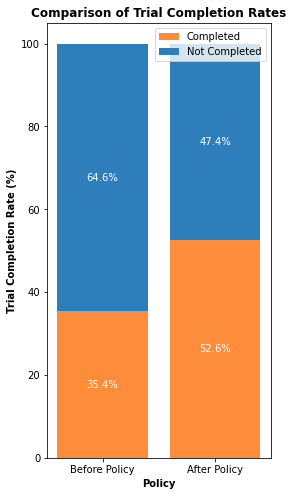

In [226]:
grouped = customer_reach.groupby(['after_policy', 'trial_completed']).size()

completion_rate_before = grouped[0][1] / grouped[0].sum() * 100
completion_rate_after = grouped[1][1] / grouped[1].sum() * 100

not_completion_rate_before = grouped[0][0] / grouped[0].sum() * 100
not_completion_rate_after = grouped[1][0] / grouped[1].sum() * 100

groups = ['Before Policy', 'After Policy']
completed_rates = [completion_rate_before, completion_rate_after]
not_completed_rates = [not_completion_rate_before, not_completion_rate_after]

fig, ax = plt.subplots(figsize=(4, 8))

cmap_orange = plt.get_cmap("Oranges")
cmap_blue = plt.get_cmap("Blues")
completed_color = cmap_orange(0.5)
not_completed_color = cmap_blue(0.7)

bars1 = ax.bar(groups, completed_rates, color=completed_color, label='Completed')
bars2 = ax.bar(groups, not_completed_rates, bottom=completed_rates, color=not_completed_color, label='Not Completed')

ax.set_xlabel('Policy', weight='bold')
ax.set_ylabel('Trial Completion Rate (%)', weight='bold')
ax.set_title('Comparison of Trial Completion Rates', weight='bold')

for bar, rate in zip(bars1, completed_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{rate:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

for bar, rate, bottom in zip(bars2, not_completed_rates, completed_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, bottom + bar.get_height() / 2, f'{rate:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

ax.legend()

plt.show()


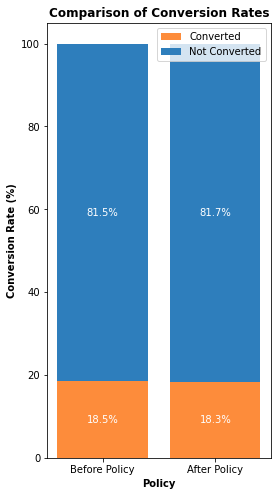

In [227]:
grouped = customer_conversion.groupby(['after_policy', 'if_converted']).size()

conversion_rate_before = grouped[0][1] / grouped[0].sum() * 100
conversion_rate_after = grouped[1][1] / grouped[1].sum() * 100

not_conversion_rate_before = grouped[0][0] / grouped[0].sum() * 100
not_conversion_rate_after = grouped[1][0] / grouped[1].sum() * 100

groups = ['Before Policy', 'After Policy']
conversion_rates = [conversion_rate_before, conversion_rate_after]
not_conversion_rates = [not_conversion_rate_before, not_conversion_rate_after]

fig, ax = plt.subplots(figsize=(4, 8))

cmap_orange = plt.get_cmap("Oranges")
cmap_blue = plt.get_cmap("Blues")
converted_color = cmap_orange(0.5)
not_converted_color = cmap_blue(0.7)

bars1 = ax.bar(groups, conversion_rates, color=converted_color, label='Converted')
bars2 = ax.bar(groups, not_conversion_rates, bottom=conversion_rates, color=not_converted_color, label='Not Converted')

ax.set_xlabel('Policy', weight='bold')
ax.set_ylabel('Conversion Rate (%)', weight='bold')
ax.set_title('Comparison of Conversion Rates', weight='bold')

for bar, rate in zip(bars1, conversion_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{rate:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

for bar, rate, bottom in zip(bars2, not_conversion_rates, conversion_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, bottom + bar.get_height() / 2, f'{rate:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

ax.legend()

plt.show()



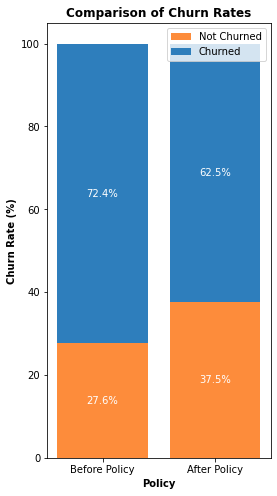

In [228]:
grouped = customer_repurchase.groupby(['after_policy', 'if_repurchase']).size()

churn_rate_before = grouped[0][0] / grouped[0].sum() * 100
churn_rate_after = grouped[1][0] / grouped[1].sum() * 100

not_churn_rate_before = grouped[0][1] / grouped[0].sum() * 100
not_churn_rate_after = grouped[1][1] / grouped[1].sum() * 100

groups = ['Before Policy', 'After Policy']
churn_rates = [churn_rate_before, churn_rate_after]
not_churn_rates = [not_churn_rate_before, not_churn_rate_after]

fig, ax = plt.subplots(figsize=(4, 8))

cmap_orange = plt.get_cmap("Oranges")
cmap_blue = plt.get_cmap("Blues")
churned_color = cmap_blue(0.7)
not_churned_color = cmap_orange(0.5)

bars1 = ax.bar(groups, not_churn_rates, color=not_churned_color, label='Not Churned')

bars2 = ax.bar(groups, churn_rates, bottom=not_churn_rates, color=churned_color, label='Churned')

ax.set_xlabel('Policy', weight='bold')
ax.set_ylabel('Churn Rate (%)', weight='bold')
ax.set_title('Comparison of Churn Rates', weight='bold')

for bar, rate in zip(bars1, not_churn_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{rate:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

for bar, rate, bottom in zip(bars2, churn_rates, not_churn_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, bottom + bar.get_height() / 2, f'{rate:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)


ax.legend()

plt.show()


### Product Types

In [145]:
product_want_list = customer_reach['product_want'].unique().tolist()
attribute_product_want = attribute[attribute['attri_id'].isin(product_want_list)]
attribute_product_want

,attri_id,attri_name,attri_name_en,pid
454,567,日常旅游,None,0.0
455,568,青少儿,None,0.0
456,569,商务面试外贸,None,0.0
457,570,应试课程,None,0.0
458,571,日语,None,0.0
776,999,行业英语,,0.0
777,1000,西班牙语,None,0.0
778,1001,德语,None,0.0
806,1035,青少儿2（不固定老师）,None,0.0


In [222]:
product_reach = customer_reach.dropna (subset=['product_want'])

In [223]:
product_reach['product_want'].replace(1035, 568, inplace=True)

product_reach['product_want'].replace(1000, 571, inplace=True)
product_reach['product_want'].replace(1001, 571, inplace=True)

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/3241396837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_reach['product_want'].replace(1035, 568, inplace=True)
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/3241396837.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_reach['product_want'].replace(1000, 571, inplace=True)
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/3241396837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [224]:
product_reach['product_want'].value_counts()

568.0    72804
567.0    63822
569.0     6309
570.0     5406
571.0     4013
999.0      401
Name: product_want, dtype: int64

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/1194909475.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_reach['product_want'] = product_reach['product_want'].map(product_dict)


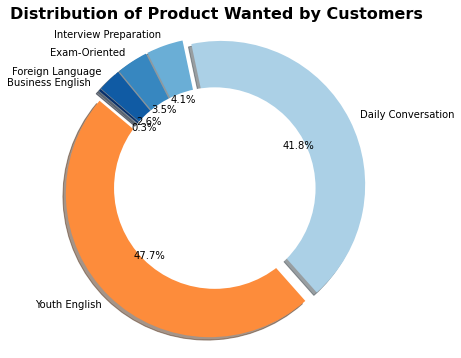

In [225]:
product_dict = {567: 'Daily Conversation', 568: 'Youth English', 
                569: 'Interview Preparation', 570: 'Exam-Oriented',
                571: 'Foreign Language', 999: 'Business English'}

product_reach['product_want'] = product_reach['product_want'].map(product_dict)

product_want_counts = product_reach['product_want'].value_counts()

labels = product_want_counts.index

sizes = product_want_counts.values

cmap_blue = plt.get_cmap('Blues')
colors = []
num_products = len(labels)
for i, label in enumerate(labels):
    if label == 'Youth English':
        colors.append(plt.get_cmap('Oranges')(0.5)) 
    else:
        colors.append(cmap_blue((i + 1) / num_products))  

explode = [0.05] * len(labels)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, startangle=140,labeldistance=1.08, pctdistance=0.6, autopct='%1.1f%%')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')

plt.title('Distribution of Product Wanted by Customers', weight='bold', fontsize=16)
plt.show()


In [150]:
product_reach['product_want'] = product_reach['product_want'].replace(
    to_replace=[name for name in product_dict.values() if name not in ['Daily Conversation', 'Youth English']],
    value='Other'
)

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/1139203099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_reach['product_want'] = product_reach['product_want'].replace(


In [151]:
product_reach_before_policy =  product_reach[product_reach['reg_date'] <= '2021-07-24']
product_reach_after_policy =  product_reach[product_reach['reg_date'] > '2021-07-24']

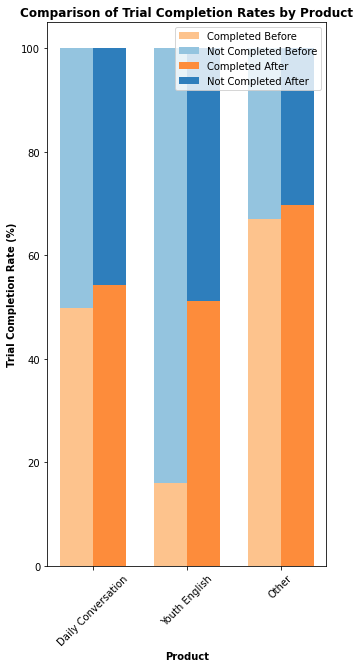

In [232]:
grouped_before = product_reach_before_policy.groupby(['product_want', 'trial_completed']).size()
grouped_after = product_reach_after_policy.groupby(['product_want', 'trial_completed']).size()

product_names = ['Daily Conversation', 'Youth English', 'Other']

completion_rates_before = [grouped_before[product][1] / grouped_before[product].sum() * 100 if product in grouped_before and 1 in grouped_before[product] else 0 for product in product_names]
not_completion_rates_before = [grouped_before[product][0] / grouped_before[product].sum() * 100 if product in grouped_before and 0 in grouped_before[product] else 0 for product in product_names]

completion_rates_after = [grouped_after[product][1] / grouped_after[product].sum() * 100 if product in grouped_after and 1 in grouped_after[product] else 0 for product in product_names]
not_completion_rates_after = [grouped_after[product][0] / grouped_after[product].sum() * 100 if product in grouped_after and 0 in grouped_after[product] else 0 for product in product_names]

fig, ax = plt.subplots(figsize=(5, 10))

bar_width = 0.35

cmap_orange = plt.get_cmap("Oranges")
cmap_blue = plt.get_cmap("Blues")
completed_color_before = cmap_orange(0.3)  
not_completed_color_before = cmap_blue(0.4) 

completed_color_after = cmap_orange(0.5) 
not_completed_color_after = cmap_blue(0.7)  

bars1_before = ax.bar(np.arange(len(product_names)) - bar_width/2, completion_rates_before, bar_width, color=completed_color_before, label='Completed Before')
bars2_before = ax.bar(np.arange(len(product_names)) - bar_width/2, not_completion_rates_before, bar_width, bottom=completion_rates_before, color=not_completed_color_before, label='Not Completed Before')

bars1_after = ax.bar(np.arange(len(product_names)) + bar_width/2, completion_rates_after, bar_width, color=completed_color_after, label='Completed After')
bars2_after = ax.bar(np.arange(len(product_names)) + bar_width/2, not_completion_rates_after, bar_width, bottom=completion_rates_after, color=not_completed_color_after, label='Not Completed After')

ax.set_xlabel('Product', weight='bold')
ax.set_ylabel('Trial Completion Rate (%)', weight='bold')
ax.set_title('Comparison of Trial Completion Rates by Product', weight='bold')

ax.set_xticks(np.arange(len(product_names)))
ax.set_xticklabels(product_names, rotation=45)


ax.legend()

plt.show()


In [190]:
product_conversion = customer_conversion.dropna (subset=['product_want'])

In [191]:
product_conversion['product_want'].replace({1035: 568, 1000: 571, 1001: 571}, inplace=True)

product_dict_new = {567: 'Daily Conversation', 568: 'Teenager English', 
                569: 'Other', 570: 'Other',
                571: 'Other', 999: 'Other'}

product_conversion['product_want'] = product_conversion['product_want'].map(product_dict_new)

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/676472028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_conversion['product_want'].replace({1035: 568, 1000: 571, 1001: 571}, inplace=True)
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/676472028.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_conversion['product_want'] = product_conversion['product_want'].map(product_dict_new)


In [192]:
product_conversion_before_policy =  product_conversion[product_conversion['reg_date'] <= '2021-07-24']
product_conversion_after_policy = product_conversion[product_conversion['reg_date'] > '2021-07-24']

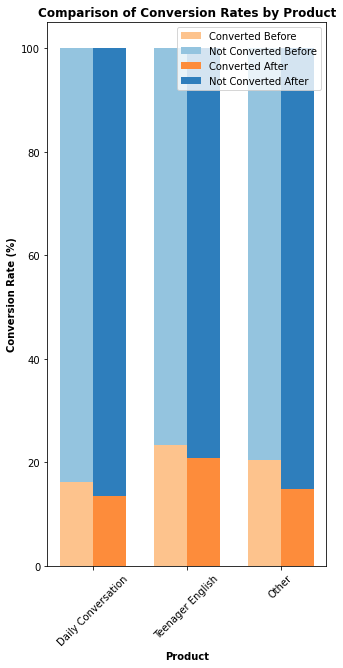

In [233]:
grouped_before = product_conversion_before_policy.groupby(['product_want', 'if_converted']).size()
grouped_after = product_conversion_after_policy.groupby(['product_want', 'if_converted']).size()

product_names = ['Daily Conversation', 'Teenager English', 'Other']

conversion_rates_before = [grouped_before[product][1] / grouped_before[product].sum() * 100 if product in grouped_before and 1 in grouped_before[product] else 0 for product in product_names]
not_conversion_rates_before = [grouped_before[product][0] / grouped_before[product].sum() * 100 if product in grouped_before and 0 in grouped_before[product] else 0 for product in product_names]

conversion_rates_after = [grouped_after[product][1] / grouped_after[product].sum() * 100 if product in grouped_after and 1 in grouped_after[product] else 0 for product in product_names]
not_conversion_rates_after = [grouped_after[product][0] / grouped_after[product].sum() * 100 if product in grouped_after and 0 in grouped_after[product] else 0 for product in product_names]

fig, ax = plt.subplots(figsize=(5, 10))

bar_width = 0.35

cmap_orange = plt.get_cmap("Oranges")
cmap_blue = plt.get_cmap("Blues")
converted_color_before = cmap_orange(0.3)  
not_converted_color_before = cmap_blue(0.4)  

converted_color_after = cmap_orange(0.5)  
not_converted_color_after = cmap_blue(0.7)  

bars1_before = ax.bar(np.arange(len(product_names)) - bar_width/2, conversion_rates_before, bar_width, color=converted_color_before, label='Converted Before')
bars2_before = ax.bar(np.arange(len(product_names)) - bar_width/2, not_conversion_rates_before, bar_width, bottom=conversion_rates_before, color=not_converted_color_before, label='Not Converted Before')

bars1_after = ax.bar(np.arange(len(product_names)) + bar_width/2, conversion_rates_after, bar_width, color=converted_color_after, label='Converted After')
bars2_after = ax.bar(np.arange(len(product_names)) + bar_width/2, not_conversion_rates_after, bar_width, bottom=conversion_rates_after, color=not_converted_color_after, label='Not Converted After')

ax.set_xlabel('Product', weight='bold')
ax.set_ylabel('Conversion Rate (%)', weight='bold')
ax.set_title('Comparison of Conversion Rates by Product', weight='bold')

ax.set_xticks(np.arange(len(product_names)))
ax.set_xticklabels(product_names, rotation=45)


ax.legend()

plt.show()


In [200]:
product_repurchase = customer_repurchase.dropna (subset=['product_want'])

In [201]:
product_repurchase['product_want'].replace(1035, 568, inplace=True)

product_repurchase['product_want'].replace(1000, 571, inplace=True)
product_repurchase['product_want'].replace(1001, 571, inplace=True)

product_repurchase['product_want'] = product_repurchase['product_want'].map(product_dict_new)

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/2433108498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_repurchase['product_want'].replace(1035, 568, inplace=True)
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/2433108498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_repurchase['product_want'].replace(1000, 571, inplace=True)
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/2433108498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [202]:
product_repurchase_before_policy =  product_repurchase[product_repurchase['reg_date'] <= '2021-07-24']
product_repurchase_after_policy = product_repurchase[product_repurchase['reg_date'] > '2021-07-24']

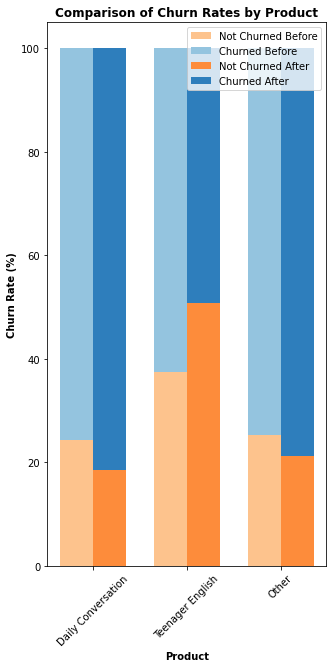

In [234]:
grouped_before = product_repurchase_before_policy.groupby(['product_want', 'if_repurchase']).size()
grouped_after = product_repurchase_after_policy.groupby(['product_want', 'if_repurchase']).size()

product_names = ['Daily Conversation', 'Teenager English', 'Other']

churn_rates_before = [grouped_before.get((product, 0), 0) / (grouped_before.get((product, 0), 0) + grouped_before.get((product, 1), 0)) * 100 if (product, 0) in grouped_before or (product, 1) in grouped_before else 0 for product in product_names]
not_churn_rates_before = [grouped_before.get((product, 1), 0) / (grouped_before.get((product, 0), 0) + grouped_before.get((product, 1), 0)) * 100 if (product, 0) in grouped_before or (product, 1) in grouped_before else 0 for product in product_names]

churn_rates_after = [grouped_after.get((product, 0), 0) / (grouped_after.get((product, 0), 0) + grouped_after.get((product, 1), 0)) * 100 if (product, 0) in grouped_after or (product, 1) in grouped_after else 0 for product in product_names]
not_churn_rates_after = [grouped_after.get((product, 1), 0) / (grouped_after.get((product, 0), 0) + grouped_after.get((product, 1), 0)) * 100 if (product, 0) in grouped_after or (product, 1) in grouped_after else 0 for product in product_names]

fig, ax = plt.subplots(figsize=(5, 10))

bar_width = 0.35

cmap_orange = plt.get_cmap("Oranges")
cmap_blue = plt.get_cmap("Blues")
churned_color_before = cmap_blue(0.4) 
not_churned_color_before = cmap_orange(0.3) 

churned_color_after = cmap_blue(0.7)  
not_churned_color_after = cmap_orange(0.5) 

bars1_before = ax.bar(np.arange(len(product_names)) - bar_width/2, not_churn_rates_before, bar_width, color=not_churned_color_before, label='Not Churned Before')
bars2_before = ax.bar(np.arange(len(product_names)) - bar_width/2, churn_rates_before, bar_width, bottom=not_churn_rates_before, color=churned_color_before, label='Churned Before')

bars1_after = ax.bar(np.arange(len(product_names)) + bar_width/2, not_churn_rates_after, bar_width, color=not_churned_color_after, label='Not Churned After')
bars2_after = ax.bar(np.arange(len(product_names)) + bar_width/2, churn_rates_after, bar_width, bottom=not_churn_rates_after, color=churned_color_after, label='Churned After')

ax.set_xlabel('Product', weight='bold')
ax.set_ylabel('Churn Rate (%)', weight='bold')
ax.set_title('Comparison of Churn Rates by Product', weight='bold')

ax.set_xticks(np.arange(len(product_names)))
ax.set_xticklabels(product_names, rotation=45)

ax.legend()

plt.show()


### Converted Time

In [161]:
trial_class_completed = trial_class_completed.merge(class_detail,on='class_id',how='left')
trial_class_completed

,class_order_id,class_id,user_id,class_order_status,pay_type,start_time
0,20277,91114,131640,2,26,1451552400
1,20278,92907,131641,2,26,1451552400
2,20280,90632,131638,2,26,1451703600
3,20310,84149,131648,2,26,1451642400
4,20312,93459,131650,2,26,1451646000
...,...,...,...,...,...,...
61603,1365395,2932720,16570373,2,26,1690891200
61604,1365933,2943138,16573591,2,26,1690981200
61605,1366330,2935704,16573717,2,26,1691114400
61606,1366704,2915901,16579517,2,26,1691067600


In [162]:
trial_class_completed['start_time'] = pd.to_datetime(trial_class_completed['start_time'], unit='s')

china_tz = pytz.timezone('Asia/Shanghai')
trial_class_completed['start_time'] = trial_class_completed['start_time'].dt.tz_localize(pytz.utc).dt.tz_convert(china_tz)

trial_class_completed['start_time'] = trial_class_completed['start_time'].dt.strftime('%Y-%m-%d %H:%M')

trial_class_completed

,class_order_id,class_id,user_id,class_order_status,pay_type,start_time
0,20277,91114,131640,2,26,2015-12-31 17:00
1,20278,92907,131641,2,26,2015-12-31 17:00
2,20280,90632,131638,2,26,2016-01-02 11:00
3,20310,84149,131648,2,26,2016-01-01 18:00
4,20312,93459,131650,2,26,2016-01-01 19:00
...,...,...,...,...,...,...
61603,1365395,2932720,16570373,2,26,2023-08-01 20:00
61604,1365933,2943138,16573591,2,26,2023-08-02 21:00
61605,1366330,2935704,16573717,2,26,2023-08-04 10:00
61606,1366704,2915901,16579517,2,26,2023-08-03 21:00


In [163]:
trial_class_sorted = trial_class_completed.sort_values(by='start_time', ascending=True)
trial_class_first = trial_class_sorted.drop_duplicates(subset='user_id', keep='first')
trial_class_first

,class_order_id,class_id,user_id,class_order_status,pay_type,start_time
0,20277,91114,131640,2,26,2015-12-31 17:00
1,20278,92907,131641,2,26,2015-12-31 17:00
5,20313,92883,131651,2,26,2016-01-01 16:00
3,20310,84149,131648,2,26,2016-01-01 18:00
4,20312,93459,131650,2,26,2016-01-01 19:00
...,...,...,...,...,...,...
61593,1362901,2882031,16561497,2,26,2023-07-28 15:00
61601,1364481,2920464,16574856,2,26,2023-07-29 22:00
61598,1364090,2851306,16567163,2,26,2023-07-30 20:00
61602,1364982,2910370,16569295,2,26,2023-08-01 20:00


In [164]:
trial_class_first = trial_class_first.merge(order_new_first[['user_id','order_date']],on='user_id',how='left')
trial_class_first

,class_order_id,class_id,user_id,class_order_status,pay_type,start_time,order_date
0,20277,91114,131640,2,26,2015-12-31 17:00,NaN
1,20278,92907,131641,2,26,2015-12-31 17:00,NaN
2,20313,92883,131651,2,26,2016-01-01 16:00,NaN
3,20310,84149,131648,2,26,2016-01-01 18:00,2016-01-04 10:29
4,20312,93459,131650,2,26,2016-01-01 19:00,2016-01-02 13:29
...,...,...,...,...,...,...,...
59577,1362901,2882031,16561497,2,26,2023-07-28 15:00,2023-07-25 19:10
59578,1364481,2920464,16574856,2,26,2023-07-29 22:00,NaN
59579,1364090,2851306,16567163,2,26,2023-07-30 20:00,NaN
59580,1364982,2910370,16569295,2,26,2023-08-01 20:00,NaN


In [165]:
trial_class_first['order_date'] = pd.to_datetime(trial_class_first['order_date'])
trial_class_first['start_time'] = pd.to_datetime(trial_class_first['start_time'])

trial_class_first['convert_time']=(trial_class_first['order_date'] - trial_class_first['start_time']).dt.days
trial_class_first

,class_order_id,class_id,user_id,class_order_status,pay_type,start_time,order_date,convert_time
0,20277,91114,131640,2,26,2015-12-31 17:00:00,NaT,NaN
1,20278,92907,131641,2,26,2015-12-31 17:00:00,NaT,NaN
2,20313,92883,131651,2,26,2016-01-01 16:00:00,NaT,NaN
3,20310,84149,131648,2,26,2016-01-01 18:00:00,2016-01-04 10:29:00,2.0
4,20312,93459,131650,2,26,2016-01-01 19:00:00,2016-01-02 13:29:00,0.0
...,...,...,...,...,...,...,...,...
59577,1362901,2882031,16561497,2,26,2023-07-28 15:00:00,2023-07-25 19:10:00,-3.0
59578,1364481,2920464,16574856,2,26,2023-07-29 22:00:00,NaT,NaN
59579,1364090,2851306,16567163,2,26,2023-07-30 20:00:00,NaT,NaN
59580,1364982,2910370,16569295,2,26,2023-08-01 20:00:00,NaT,NaN


In [166]:
converted_user = trial_class_first[trial_class_first['convert_time'].notnull()].copy()
converted_user = converted_user[converted_user['convert_time']>=0]
converted_user = converted_user[converted_user['convert_time']<=180]
converted_user

,class_order_id,class_id,user_id,class_order_status,pay_type,start_time,order_date,convert_time
3,20310,84149,131648,2,26,2016-01-01 18:00:00,2016-01-04 10:29:00,2.0
4,20312,93459,131650,2,26,2016-01-01 19:00:00,2016-01-02 13:29:00,0.0
31,20611,94772,131698,2,26,2016-01-05 12:00:00,2016-01-05 14:32:00,0.0
39,20584,94483,131665,2,26,2016-01-05 20:00:00,2016-01-06 13:35:00,0.0
41,20761,92267,131732,2,26,2016-01-05 21:00:00,2016-01-06 14:59:00,0.0
...,...,...,...,...,...,...,...,...
59553,1350288,2885687,16576695,2,26,2023-06-27 19:00:00,2023-06-30 22:26:00,3.0
59559,1351738,2905390,16563857,2,26,2023-06-30 16:00:00,2023-06-30 21:40:00,0.0
59564,1354261,2914669,16563726,2,26,2023-07-08 19:00:00,2023-07-10 20:14:00,2.0
59566,1356848,2916799,16577932,2,26,2023-07-12 20:00:00,2023-07-18 11:17:00,5.0


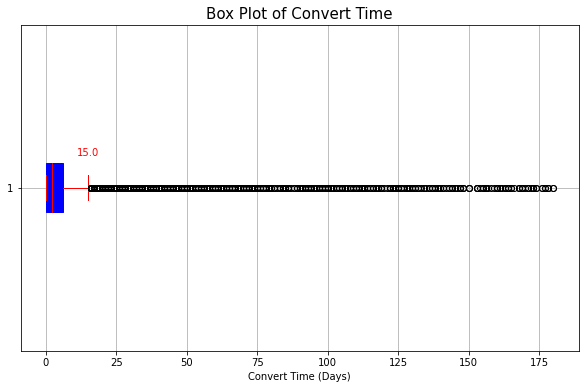

In [167]:
fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(converted_user['convert_time'], vert=False, patch_artist=True, boxprops=dict(facecolor='blue', color='blue'),
            whiskerprops=dict(color='red'), capprops=dict(color='red'), medianprops=dict(color='red'))

ax.set_title('Box Plot of Convert Time', fontsize=15)
ax.set_xlabel('Convert Time (Days)')
ax.grid(True)

upper_whisker_position = bp['whiskers'][1].get_xdata()[1]  # [1] is for upper whisker, get_xdata()[1] is for whisker end
ax.text(upper_whisker_position, 1.1, f"{upper_whisker_position:.1f}", horizontalalignment='center', color='red')

plt.show()


### Trial Price Distribution

In [168]:
trial_price = customer_reach.dropna(subset=['product_money'])
trial_price = customer_reach[customer_reach['product_money']<100]

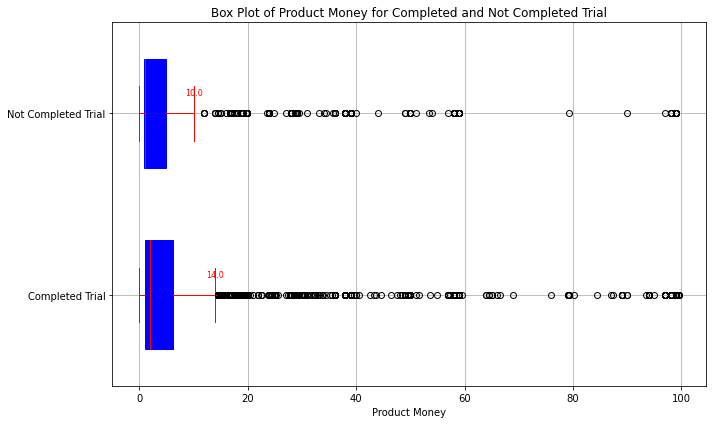

In [169]:
fig, ax = plt.subplots(figsize=(10, 6))

completed_trial = trial_price[trial_price['trial_completed'] == 1]['product_money']
bp_completed = ax.boxplot(completed_trial.dropna(), positions=[1], widths=0.6, vert=False, patch_artist=True, 
                          boxprops=dict(facecolor='blue', color='blue'),
                          whiskerprops=dict(color='red'),
                          capprops=dict(color='red'),
                          medianprops=dict(color='red'))

upper_whisker_completed = bp_completed['whiskers'][1].get_xdata()[1]
ax.text(upper_whisker_completed, 1.1, f"{upper_whisker_completed:.1f}", 
        horizontalalignment='center', color='red', fontsize=8)

not_completed_trial = trial_price[trial_price['trial_completed'] == 0]['product_money']
bp_not_completed = ax.boxplot(not_completed_trial.dropna(), positions=[2], widths=0.6, vert=False, patch_artist=True, 
                              boxprops=dict(facecolor='blue', color='blue'),
                              whiskerprops=dict(color='red'),
                              capprops=dict(color='red'),
                              medianprops=dict(color='red'))

upper_whisker_not_completed = bp_not_completed['whiskers'][1].get_xdata()[1]
ax.text(upper_whisker_not_completed, 2.1, f"{upper_whisker_not_completed:.1f}", 
        horizontalalignment='center', color='red', fontsize=8)

ax.set_title('Box Plot of Product Money for Completed and Not Completed Trial')
ax.set_xlabel('Product Money')
ax.set_yticks([1, 2])
ax.set_yticklabels(['Completed Trial', 'Not Completed Trial'])
ax.grid(True)

plt.tight_layout()
plt.show()


### Product Price

In [170]:
price_repurchase = customer_repurchase.dropna (subset=['product_money'])

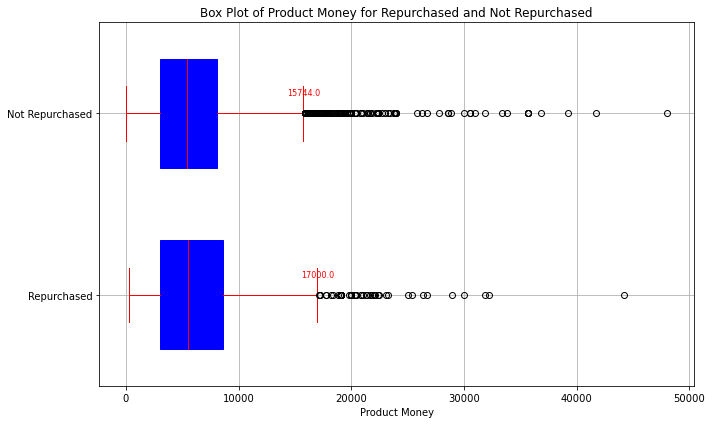

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))

repurchased = price_repurchase[price_repurchase['if_repurchase'] == 1]['product_money']
bp_repurchased = ax.boxplot(repurchased.dropna(), positions=[1], widths=0.6, vert=False, patch_artist=True, 
                            boxprops=dict(facecolor='blue', color='blue'),
                            whiskerprops=dict(color='red'),
                            capprops=dict(color='red'),
                            medianprops=dict(color='red'))

upper_whisker_repurchased = bp_repurchased['whiskers'][1].get_xdata()[1]
ax.text(upper_whisker_repurchased, 1.1, f"{upper_whisker_repurchased:.1f}", 
        horizontalalignment='center', color='red', fontsize=8)

not_repurchased = price_repurchase[price_repurchase['if_repurchase'] == 0]['product_money']
bp_not_repurchased = ax.boxplot(not_repurchased.dropna(), positions=[2], widths=0.6, vert=False, patch_artist=True, 
                                boxprops=dict(facecolor='blue', color='blue'),
                                whiskerprops=dict(color='red'),
                                capprops=dict(color='red'),
                                medianprops=dict(color='red'))

upper_whisker_not_repurchased = bp_not_repurchased['whiskers'][1].get_xdata()[1]
ax.text(upper_whisker_not_repurchased, 2.1, f"{upper_whisker_not_repurchased:.1f}", 
        horizontalalignment='center', color='red', fontsize=8)

ax.set_title('Box Plot of Product Money for Repurchased and Not Repurchased')
ax.set_xlabel('Product Money')
ax.set_yticks([1, 2])
ax.set_yticklabels(['Repurchased', 'Not Repurchased'])
ax.grid(True)

plt.tight_layout()
plt.show()


### Time-Series

#### New Member Joined by Time

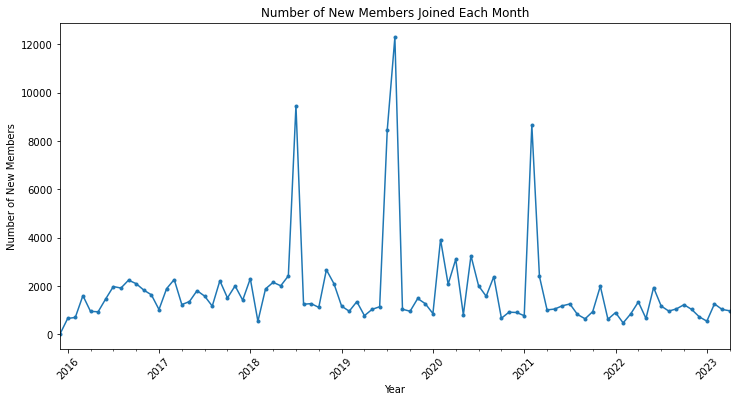

In [172]:
customer_reach['reg_date'] = pd.to_datetime(customer_reach['reg_date'])

customer_reach['year_month'] = customer_reach['reg_date'].dt.to_period('M')

monthly_counts = customer_reach.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(12, 6))
monthly_counts.plot(kind='line', marker='.',markersize=6, ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Number of New Members')
ax.set_title('Number of New Members Joined Each Month')

plt.xticks(rotation=45)

plt.show()

#### Trial Class Completed by Time

In [173]:
trial_class_completed = trial_class_completed[trial_class_completed['start_time'] < '2023-05-01']

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/2291306977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_class_completed['start_time'] = pd.to_datetime(trial_class_completed['start_time'])
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/2291306977.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_class_completed['year_month'] = trial_class_completed['start_time'].dt.to_period('M')


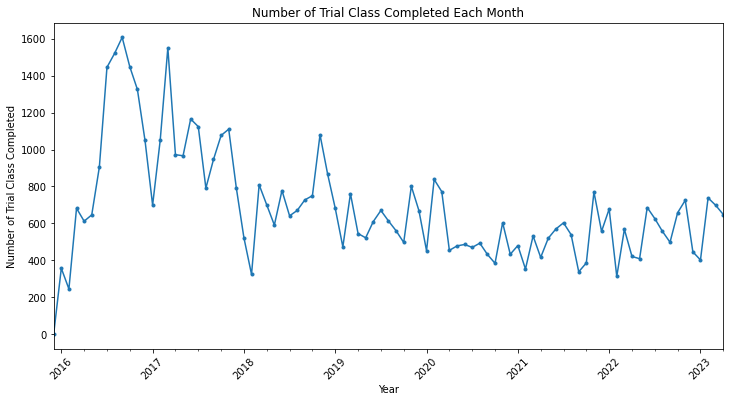

In [174]:
trial_class_completed['start_time'] = pd.to_datetime(trial_class_completed['start_time'])

trial_class_completed['year_month'] = trial_class_completed['start_time'].dt.to_period('M')

monthly_counts = trial_class_completed.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(12, 6))
monthly_counts.plot(kind='line', marker='.',markersize=6, ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Trial Class Completed')
ax.set_title('Number of Trial Class Completed Each Month')

plt.xticks(rotation=45)

plt.show()

#### New Orders Placed by Time

In [175]:
order_new['add_date'] = pd.to_datetime(order_new['add_date'], unit='s')

china_tz = pytz.timezone('Asia/Shanghai')
order_new['add_date'] = order_new['add_date'].dt.tz_localize(pytz.utc).dt.tz_convert(china_tz)

order_new['add_date'] = order_new['add_date'].dt.strftime('%Y-%m-%d %H:%M')

order_new

,user_id,product_id,product_name,buy_type,add_date,effective_date,overdue_date,lesson,unit_price,product_money
5749,131650.0,21.0,菲律宾外教次卡,105.0,2016-01-02 13:29,1.452308e+09,1.460602e+09,32.0,70.1,2244.0
5750,131669.0,25.0,欧美外教次卡,105.0,2016-01-02 13:30,1.455611e+09,1.468053e+09,48.0,149.4,7172.0
5770,131648.0,25.0,欧美外教次卡,105.0,2016-01-04 10:29,1.452072e+09,1.454146e+09,8.0,143.0,1144.0
5845,131698.0,25.0,欧美外教次卡,105.0,2016-01-05 14:32,1.451979e+09,1.464680e+09,49.0,146.0,7152.0
5849,131730.0,25.0,欧美外教次卡,105.0,2016-01-05 16:18,1.452816e+09,1.456963e+09,16.0,138.9,2223.0
...,...,...,...,...,...,...,...,...,...,...
231251,16569641.0,25.0,欧美外教次卡,710.0,2023-07-28 12:18,1.690789e+09,1.703749e+09,50.0,180.0,8999.0
231506,16571932.0,25.0,欧美外教次卡,3000.0,2023-07-30 17:36,NaN,NaN,28.0,184.2,5159.0
231514,16576688.0,25.0,欧美外教次卡,715.0,2023-07-30 19:35,1.690717e+09,1.703159e+09,48.0,187.5,8999.0
231618,16561991.0,25.0,欧美外教次卡,710.0,2023-07-31 17:40,NaN,NaN,9.0,222.2,2000.0


In [176]:
order_new = order_new[order_new['add_date'] < '2023-05-01']

/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/4250862177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_new['add_date'] = pd.to_datetime(order_new['add_date'])
/var/folders/b9/g48b_66n63n3rwlbb7dhxm0r0000gn/T/ipykernel_50086/4250862177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_new['year_month'] = order_new['add_date'].dt.to_period('M')


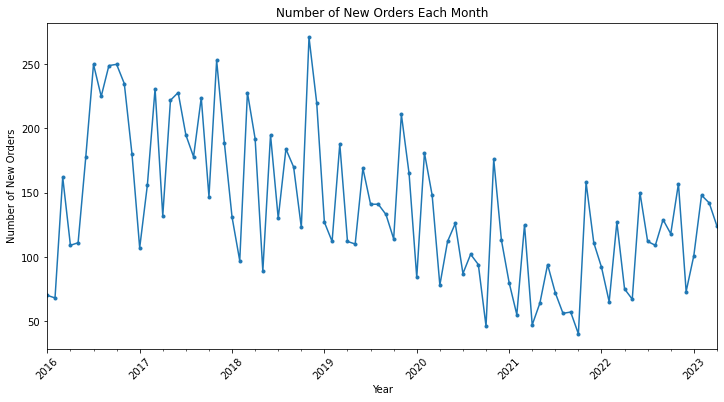

In [177]:
order_new['add_date'] = pd.to_datetime(order_new['add_date'])

order_new['year_month'] = order_new['add_date'].dt.to_period('M')

monthly_counts = order_new.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(12, 6))
monthly_counts.plot(kind='line', marker='.',markersize=6, ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Number of New Orders')
ax.set_title('Number of New Orders Each Month')

plt.xticks(rotation=45)

plt.show()